In [1]:
import networkx as nx
import random
import copy
import time
import matplotlib.pyplot as plt
import sys
from collections import defaultdict
%matplotlib inline

        
def kawai_draw(G, infected=[]) :
    colors = []
    for node in G :
        if node in infected :
            colors.append('red')
        else :
            colors.append('green')
    nx.draw(G, layout=nx.kamada_kawai_layout(G), node_color=colors, node_size = 30, alpha = 0.7)
    plt.show()
    
num_nodes = 1000
 
G = nx.barabasi_albert_graph(num_nodes, 3)

#G = nx.watts_strogatz_graph(num_nodes, 6, 1)

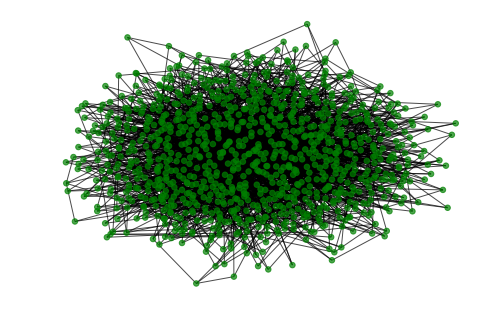

In [2]:
kawai_draw(G)

In [3]:
import networkx as nx
import copy
import time
start = time.time()

spl = nx.all_pairs_shortest_path_length(G)

def change_ds(spl_gen, num_nodes, max_radius):
    ''' Transforms 'spl_gen' into the accepted datastructure
        by the 'infected_average_by_separation_degree' method
    '''
    result = []
    for n in range(num_nodes):
        di_tmp = {}
        for entry in spl_gen:  
            for radius in range(1, max_radius + 1):
                li_tmp = []
                for node, dist in entry[1].items():
                    if dist == radius:
                        li_tmp.append(node)
                if li_tmp != []:
                    di_tmp[radius - 1] = li_tmp
            result.append(copy.copy(di_tmp))
            
    return result

separation_degrees = change_ds(spl, num_nodes, 6)
print('\n', time.time() - start)


 5.874975681304932


In [4]:
def infected_percentage(nodes, infected) :
    count = 0
    for node in nodes :
        if node in infected :
            count += 1
    
    return count / len(nodes)

def infected_average_by_separation_degree(G, separation_degrees, infected) :
    node_count = {}
    percentage_sum = {}
    
    for node in range(0, len(separation_degrees)) :
        if node in infected :
            for degree in separation_degrees[node] :
                if degree not in percentage_sum.keys() :
                    percentage_sum[degree] = 0
                    node_count[degree] = 0
                percentage_sum[degree] += infected_percentage(separation_degrees[node][degree], infected)
                node_count[degree] += 1
        
    average_by_separation_degree = {}
    
    for separation_degree in percentage_sum :
        average_by_separation_degree[separation_degree] = percentage_sum[separation_degree] / node_count[separation_degree]
            
    return average_by_separation_degree


In [5]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.SIModel as si
import ndlib.models.opinions.VoterModel as vt

# Model selection
model = si.SIModel(G)
#model = vt.VoterModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.05) # prob of infecteded
cfg.add_model_parameter("percentage_infected", 0) # initially infected  %
model.set_initial_status(cfg)

C:\ProgramData\Anaconda3\lib\site-packages\ndlib\models\DiffusionModel.py:161: UserWarning: Graph with less than 100 nodes: a single node will be set as infected
  warnings.warn('Graph with less than 100 nodes: a single node will be set as infected')


In [6]:
infected = []
it_count = 0
while len(infected) < num_nodes / 2 :
    it_count += 1
    iteration = model.iteration()
    for node, i in iteration['status'].items() :
        if i == 1:
            infected.append(node)
            
    
avg_traits = infected_average_by_separation_degree(G, separation_degrees, infected)
infected_count = len(infected)

print('Infected count', infected_count)
print('Iterations', it_count)
print(avg_traits)

Infected count 560
Iterations 27
{0: 0.7689025135311246, 1: 0.6800548780447312, 2: 0.6083586226783909, 3: 0.497874629385095, 4: 0.41389911483790226, 5: 0.2601337521174479}


In [7]:
''' Start Random distribution of infecteds section '''
import random

def simulate_random_infecteds(G_rand, num_nodes, radius_split_rand, num_infects):
    
    '''
    Randomly picks the same number of infecteds as in the 
    non-random model (for a each iteration of the spreading)
    Returns a list of @infected_average_by_radius lists
    '''
    random_infected = []
    random_not_infected = list(range(0, num_nodes))
    
    for _ in range(num_infects):
        new_inf = random.choice(random_not_infected)
        random_infected.append(new_inf)
        random_not_infected.remove(new_inf)

    avg_trait_sharing_by_radius = infected_average_by_separation_degree(G_rand, separation_degrees, random_infected)
    print(avg_trait_sharing_by_radius)    

    return (avg_trait_sharing_by_radius, random_infected)

avg_random_trait_sharing_by_radius, final_random_infected = simulate_random_infecteds(G, num_nodes, separation_degrees, infected_count)

{0: 0.5464133170397809, 1: 0.5393154922659386, 2: 0.5550617069292143, 3: 0.5653443151588753, 4: 0.5881946777706557, 5: 0.5673006883098916}


In [8]:
def propensity_by_radius(radius, avg_traits, rand_avg_traits):
    return (avg_traits[radius-1] / rand_avg_traits[radius-1]) - 1

def all_propensities(max_radius, avg_traits, rand_avg_traits):
    all_propensities = []
    for r in range(1, max_radius + 1):
        all_propensities.append(propensity_by_radius(r, avg_traits, rand_avg_traits))
    return all_propensities

all_props = all_propensities(6, avg_traits, avg_random_trait_sharing_by_radius)

def normalized_propensities(max_radius, all_propensities):
    normalized_propensities = []
    for r in range(max_radius):
        normalized_propensities.append(all_propensities[r] / all_propensities[0])
    
    return normalized_propensities
        
print(normalized_propensities(6, all_props))

[1.0, 0.6408923728093099, 0.2358159402037043, -0.29309472737813597, -0.7277422489732404, -1.3297607292287363]


In [9]:
#Do not delete, create list for each degree and add to report
avg = 0
for node in separation_degrees :
    if len(node) > 5 :
        avg += len(node[5])

print(avg / len(separation_degrees))

1.171


In [10]:
print(2 * G.number_of_edges() / G.number_of_nodes())

5.982


In [11]:
'''import pickle

with open('2000_nodes_scale_free.graph', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(G, f)'''

"import pickle\n\nwith open('2000_nodes_scale_free.graph', 'wb') as f:  # Python 3: open(..., 'wb')\n    pickle.dump(G, f)"

In [12]:
'''import pickle

with open('2000_nodes_scale_free.graph', 'rb') as f:  # Python 3: open(..., 'rb')
    Gtest = pickle.load(f)

print(2 * Gtest.number_of_edges() / Gtest.number_of_nodes())'''

"import pickle\n\nwith open('2000_nodes_scale_free.graph', 'rb') as f:  # Python 3: open(..., 'rb')\n    Gtest = pickle.load(f)\n\nprint(2 * Gtest.number_of_edges() / Gtest.number_of_nodes())"